**Hola!**

Mi nombre es Maria Efimova, voy a revisar tu proyecto. Encantada de conocerte :)
Está bien si hablamos en 'Tú'? Por favor, dime si eso no está bien para tí, lo cambiaremos.

Mi trabajo no es señalar los errores que cometiste, sino compartir mi experiencia y ayudarte a convertirte en analista de datos. Ya has trabajado mucho en el proyecto, pero vamos a hacerlo aún mejor. A continuación encontrará mis comentarios; no los mueva, modifique ni elimine. Usaré marcas de color:


<div class="alert alert-danger">
<b>❌ Comentario del revisor:</b> Esto destaca los comentarios más importantes. Sin su desarrollo, el proyecto no será aceptado. </div>


<div class="alert alert-warning">
<b>⚠️ Comentario del revisor:</b> Así que los pequeños comentarios están resaltados. Se aceptan uno o dos comentarios de este tipo en el borrador, pero si hay más, deberá hacer las correcciones. Es como una tarea de prueba al solicitar un trabajo: muchos pequeños errores pueden hacer que un candidato sea rechazado.

</div>

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Así que destaco todos los demás comentarios.</div>

Vamos a trabajar en el proyecto en un diálogo: si cambias algo en el proyecto o respondes a mis comentarios, escribe sobre eso. Será más fácil para mí seguir los cambios si resaltas tus comentarios asi:
<div class="alert alert-info"> <b>Comentario del estudiante:</b> Por ejemplo, asi.</div>

Todo esto ayudará a volver a revisar tu proyecto más rápido.
 

Recuerde que, si quieres dejarme un comentario en alguna parte del documento, sólo tiene que dar doble clic sobre la celda de arriba, copiar el código, pegarlo en una nueva celda y sustituir la frase "En celdas como estas puede dejarme sus comentarios" por su propio comentario. Asegúrese sólamente que la celda donde usted vaya a incluir su comentario esté en formato "Markdown".

Respecto del proceso de revisión, esta es la <b>primera iteración</b> para este ejercicio. Su proyecto será aceptado una vez que los comentarios en rojo hayan sido atendidos. Al final de este Notebook encontrará comentarios con mis observaciones finales.

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Genial que empecamos con el plan todo

## Preparación

### Carga de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

### Carga de datos

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

### Exploracion de datos

In [3]:
display(df.head())
print(df.describe())
print()
print(df.info())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


In [4]:
# Verificamos valores duplicados
df.duplicated().sum()

0

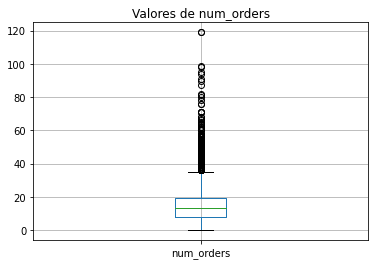

In [5]:
df.boxplot('num_orders')
plt.title('Valores de num_orders')
plt.show()

Observamos de forma rapida que solo tenemos dos columnas de datos: fecha y num de ordenes de taxi, no tenemos valores ausentes ni duplicados.

Necesitamos corregir el tipo de datos de fecha de object a datetime, y observaremos si el porcentaje de valores atipicos que estan por encima del 75% que es 19 ordenes de los datos promedio son anormales o se refieren a las horas pico. 

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Genial, aqui todo bien

In [6]:
#Conversion de datos a tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'],format = '%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Muy bien que no olvidaste sobre format

In [7]:
# Porcentaje de valores arriba de 19 ordenes 
print(round((sum(df['num_orders'] > 19)/len(df))*100,2),'% es el porcentaje de la muestra que esta por encima del 75% promedio de los datos, por lo que lo tomaremos\ncomo las horas pico' )

23.01 % es el porcentaje de la muestra que esta por encima del 75% promedio de los datos, por lo que lo tomaremos
como las horas pico


Ya que tenemos nuestra columna de fecha con el tipo correcto "datetime", pasaremos esta columna como indice y la ordenaremos en orden ascendente.

In [8]:
# Ordenamos nuestros valores de fecha en orden ascendente
df.sort_values(by='datetime',ascending=True, inplace=True)

# Definimos nuestro indice con la columna de datetime
df.set_index('datetime',inplace=True)

In [9]:
# Verificamos nuestro dataframe
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Podemos observar que tenemos registros comenzando el dia 1 de Marzo de 2018 a las 00:00hrs y finalizando el dia 31 de Agosto de 2018 a las 23:50hrs, lo que nos da un periodo de 6 meses de muestra.

Tenemos nuestros datos listos para poder hacer agrupamientos y posteriormente crear nuestros modelos.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Todo bien con esa parte!

## Análisis

Como observamos en nuestra muestra, nuestros registros estan en intervalos de 10 min y lo que necesitamos es hacer un remuestreo por hora, ya que nuestro objetivo es encontrar el valor medio de taxis por hora, dejaremos el dataframe original y crearemos uno nuevo con el remuestreo realizado.

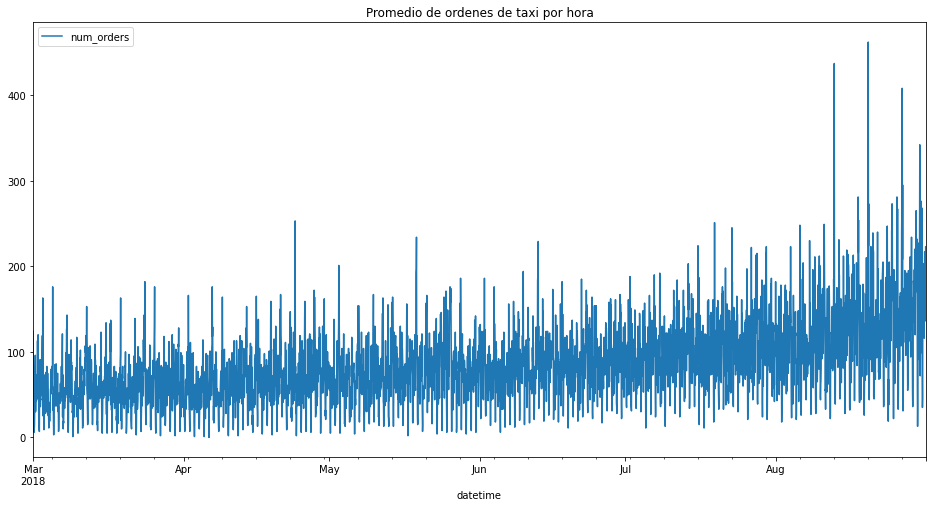

In [10]:
# Remuestreo de total de taxis por hora
df1 = df.resample('1H').sum()
df1.plot(figsize=(16,8))
plt.title('Promedio de ordenes de taxi por hora')
plt.show()

Podemos observar el remuestreo del promedio de ordenes de taxi no es muy claro realicemos un seccionamiento para ver mas de cerca los datos

### Tendencias y estacionalidad

In [11]:
def seasonal_analisis(data):
    decomposed = seasonal_decompose(data)

    plt.figure(figsize=(16, 20))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Tendencia')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Estacionalidad')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuales')
    plt.tight_layout() 

In [12]:
def rolling_graf(data,rolling_number):
    x = data
    x['rolling'] = x.rolling(rolling_number).mean()
    x.plot(figsize=(16, 8))
    plt.title('Media movil, taxis por hora')
    plt.show()

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Correcto!

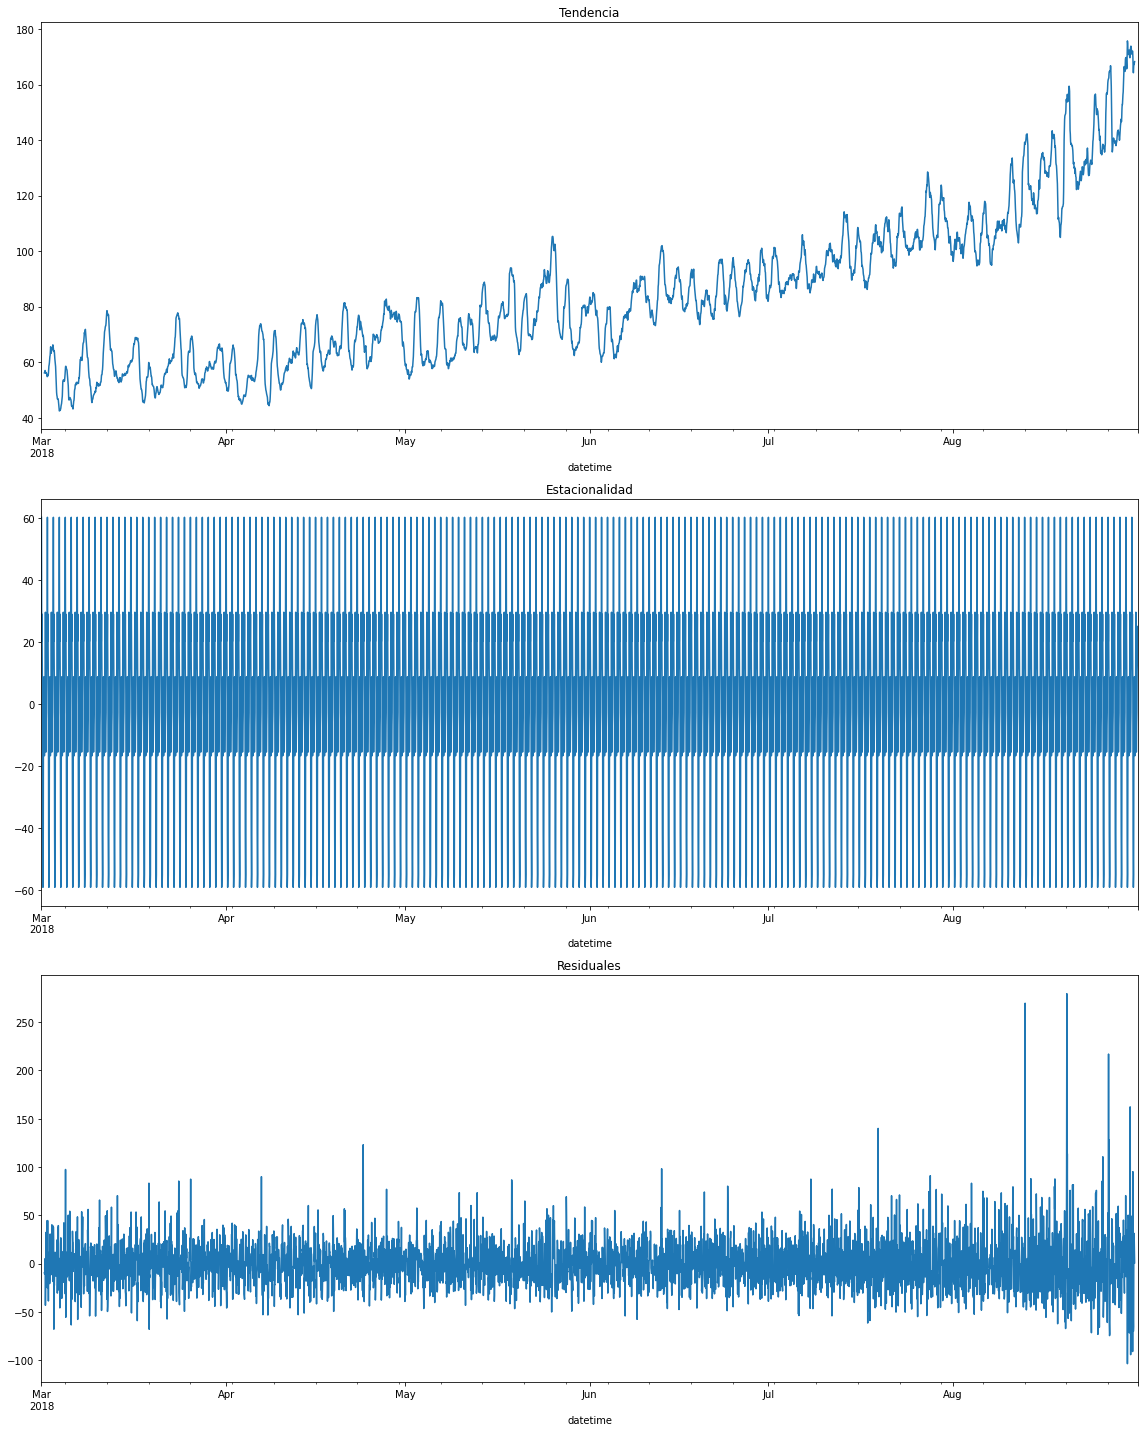

In [13]:
seasonal_analisis(df1)

Podemos observar que se tiene una tendencia en el aumento de solicitudes de taxis conforme avanza el tiempo y una estacionalidad ciclica, esto aplica para ambos conjuntos de datos, como observamos tenemos el mismo grafico pero con diferentes unidades, de ahora en adelante solo trabajaremos con el conjunto data1 que es el conjunto con el remuestreo con el promedio.

Haremos una muestra de 1 mes para ver como se comporta la tendencia

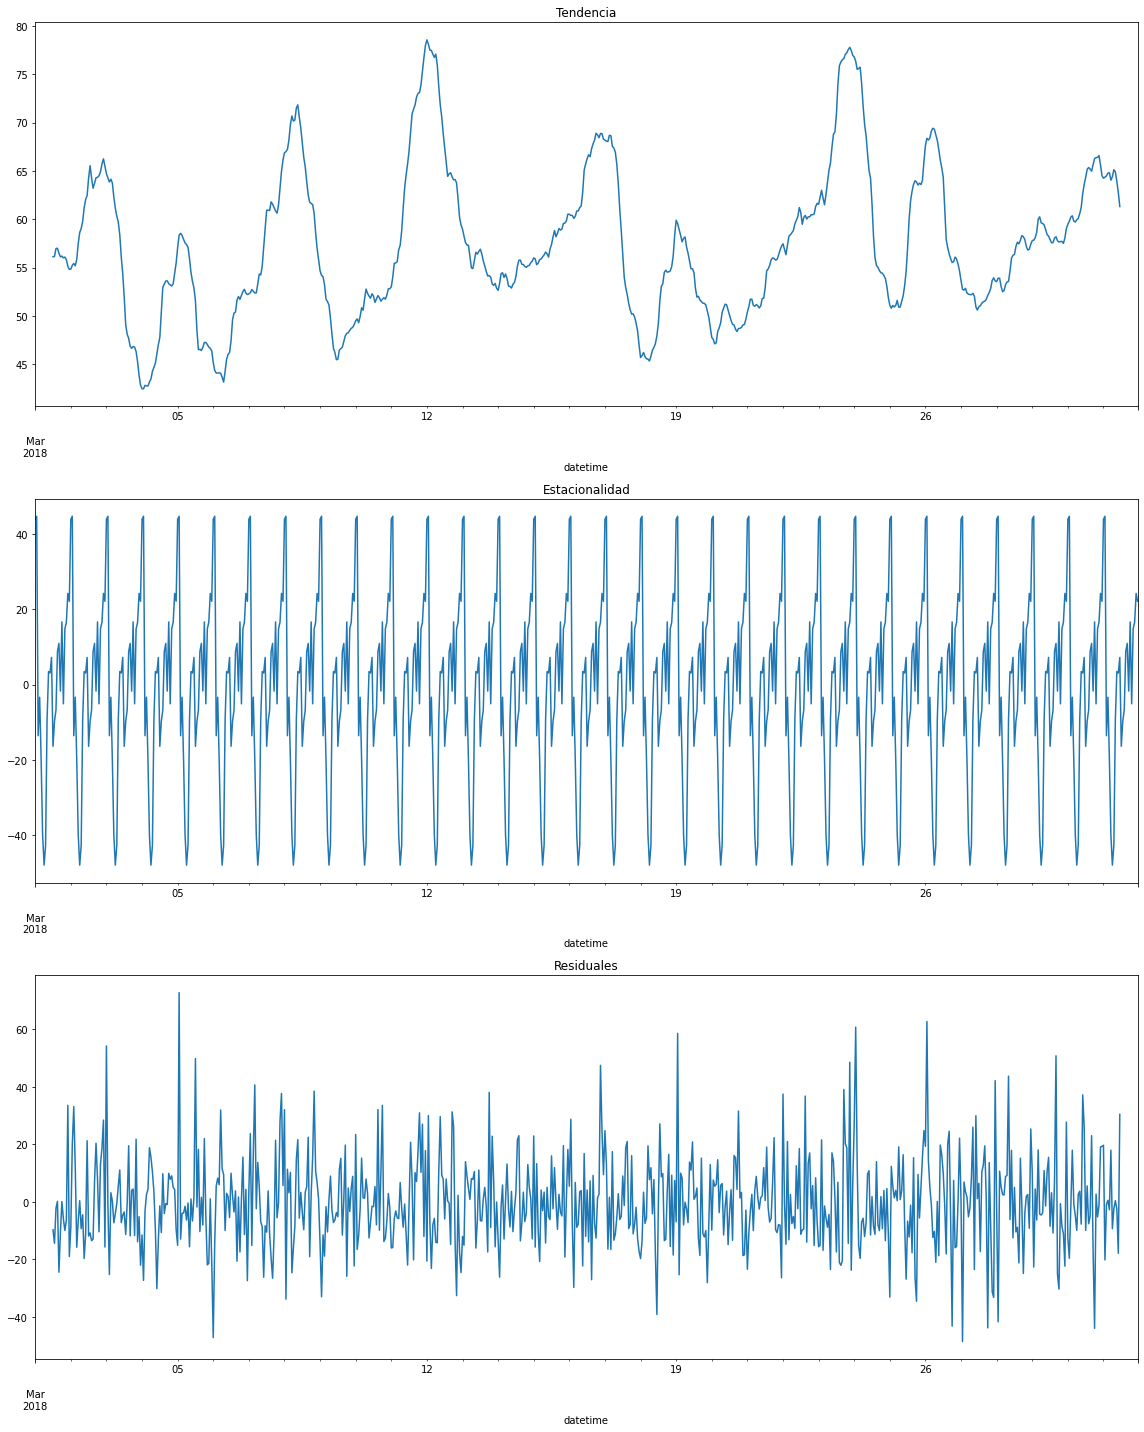

In [14]:
seasonal_analisis(df1['2018-03-01':'2018-03-31'])

/tmp/ipykernel_118/405181865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['rolling'] = x.rolling(rolling_number).mean()


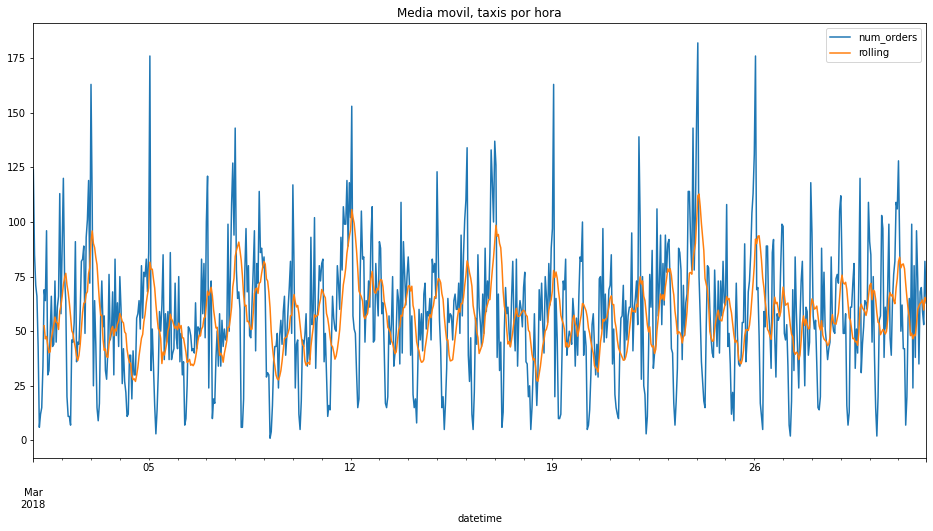

In [15]:
rolling_graf(df1['2018-03-01':'2018-03-31'],10)

Podemos ver la que tencia en el mes es similar y que tenemos una estacionalidad ciclica, de igual forma podemos ver la media movil de taxis por hora.

<div class="alert alert-info"> <b>Comentario del estudiante:</b> Se agrego la media movil.</div>

<div class="alert alert-success">
<b>✔️ Comentario del revisor v2:</b> Ahora todo bien!

## Formación

Comenzaremos con la preparacion y el entrenamiento para nuestros modelos de predicción

In [16]:
# Haremos un par de pruebas sin entrenar algun modelo
def no_train_test(data,target):
    """Con esta funcion podemos ver los valores de RECM sin utilizar un modelo entrenado con los siguientes argumentos:
    data: conjunto de datos a utilizar
    target: columna de datos objetivo
    """
    train, test = train_test_split(data,shuffle=False,test_size=0.1)
    print('Numero promedio de ordenes de taxi por hora:', round(test[target].mean(),0))
    print()
    pred_mean = pd.Series(train[target].mean(),index = test.index)
    print('RECM con valores constantes')
    print('RECM =', round(mean_squared_error(test,pred_mean,squared=False),0))
    pred_previous = test.shift()
    pred_previous.iloc[0] = train.iloc[-1]
    print()
    print('RECM con valor anterior a la serie')
    print('RECM:', round(mean_squared_error(test[target], pred_previous,squared=False),0))

In [17]:
no_train_test(df1,'num_orders')

Numero promedio de ordenes de taxi por hora: 140.0

RECM con valores constantes
RECM = 85.0

RECM con valor anterior a la serie
RECM: 59.0


Hemos obtenido valores de RECM de 84 y 59 con dos formas de predecir sin realizar algun modelo, siendo el resultado de 59 un valor "bueno", aun no conseguimos nuestra meta de 48 de RECM; procederemos a realizar entrenamiento de modelos para mejorar esta metrica.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Aqui todo bien! Funciona correcto!

### Preparacion de caracteristicas

Crearemos caracteristicas de calendario, desfase y media movil.

In [18]:
def make_features(data, max_lag, rolling_mean_size,target):
    """
    Con esta funcion crearemos caracteristicas de calendario(año,mes,dia), asi como hacer el desface de fechas y la media movil
    con los siguientes argumentos:
    data: conjunto de datos
    max_lag: desface maximo
    rolling_mean: media movil
    target: columna objetivo del conjunto data
    """
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target].shift(lag)

    data['rolling_mean'] = data[target].shift().rolling(rolling_mean_size).mean()

In [19]:
# Crearemos las caracteristicas
make_features(df1, 4, 4, 'num_orders')

In [20]:
# comprobamos que se hayan realizado correctamente las caracteriscticas
display(df1.head(10))
print(df1.shape)

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,19.00


(4416, 11)


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Genial!

Tenemos que tener en cuenta que un modelo no funciona con valores ausentes, asi que los eliminaremos

In [21]:
# Eliminacion de valores NaN
df1.dropna(inplace=True)

Realizaremos el escalamiento de datos para un mejor procesamiento

In [22]:
# Creamos nuestra funcion de escalado de datos
def maxscaler(data,columns):
    """Con esta funcion realizamos el escalamiento de datos
    data: conjunto de datos a utilizar
    columns: columnas a realizar el escalado de datos
    """
    scaler = MaxAbsScaler()
    scaler.fit(data[columns])
    data[columns] = scaler.transform(data[columns])
    return data[columns]

In [23]:
maxscaler(df1,['year', 'month', 'day', 'dayofweek','hour', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'rolling_mean'])

,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 04:00:00,1.0,0.375,0.032258,0.500000,0.173913,0.142857,0.153680,0.183983,0.268398,0.281072
2018-03-01 05:00:00,1.0,0.375,0.032258,0.500000,0.217391,0.093074,0.142857,0.153680,0.183983,0.215272
2018-03-01 06:00:00,1.0,0.375,0.032258,0.500000,0.260870,0.012987,0.093074,0.142857,0.153680,0.151097
2018-03-01 07:00:00,1.0,0.375,0.032258,0.500000,0.304348,0.025974,0.012987,0.093074,0.142857,0.103168
2018-03-01 08:00:00,1.0,0.375,0.032258,0.500000,0.347826,0.032468,0.025974,0.012987,0.093074,0.061738
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,1.0,1.000,1.000000,0.666667,0.826087,0.448052,0.469697,0.426407,0.251082,0.598700
2018-08-31 20:00:00,1.0,1.000,1.000000,0.666667,0.869565,0.294372,0.448052,0.469697,0.426407,0.614947
2018-08-31 21:00:00,1.0,1.000,1.000000,0.666667,0.913043,0.333333,0.294372,0.448052,0.469697,0.580016


Ya tenemos nuestro conjunto listo para entrenar y evaluar nuestro modelos

## Prueba

### LinearRegression

In [24]:
def linear_model(data,target):
    train, test = train_test_split(data, shuffle=False, test_size = 0.1)
    features_train = train.drop(target, axis=1)
    target_train = train[target]
    features_test = test.drop(target, axis=1)
    target_test = test[target]
    model = LinearRegression()
    model.fit(features_train,target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print('RECM para el conjunto de entrenamiento', mean_squared_error(target_train,train_pred,squared=False))
    print('RECM para el conjunto de prueba', mean_squared_error(target_test,test_pred,squared=False))

In [25]:
linear_model(df1,'num_orders')

RECM para el conjunto de entrenamiento 30.500374252442192
RECM para el conjunto de prueba 52.57450685373692


Del model de regresion lineal obtenemos un valor de RECM en el conjunto de prueba de 52, aun un valor alto para nuestro objetivo de 48, intentaremos con otro modelo

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Bien!

<div class="alert alert-warning">
<b>⚠️ Comentario del revisor:</b> Tambien seria mejor si anades los graficos aqui

### DecisionTreeRegressor

In [26]:
def tree_model(data,target):
    train, test = train_test_split(data, shuffle=False, test_size = 0.1)
    features_train = train.drop(target, axis=1)
    target_train = train[target]
    features_test = test.drop(target, axis=1)
    target_test = test[target]
    
    model = DecisionTreeRegressor(random_state=92)
    param = {'max_depth' : [None, 10],
            'min_samples_leaf': [1,2],
            'min_samples_split':[2,3]}
    gs = GridSearchCV(estimator = model,
                  param_grid = param,
                      scoring = 'neg_root_mean_squared_error',
                  cv = 5)
    gs.fit(features_train,target_train)
    
    train_pred = gs.best_estimator_.predict(features_train)
    test_pred = gs.best_estimator_.predict(features_test)
    
    print('RECM para el conjunto de entrenamiento', mean_squared_error(target_train,train_pred,squared=False))
    print('RECM para el conjunto de prueba', mean_squared_error(target_test,test_pred,squared=False))

In [27]:
tree_model(df1,'num_orders')

RECM para el conjunto de entrenamiento 16.996013468360996
RECM para el conjunto de prueba 52.66700307161063


Tenemos un resultado no muy favorable, un RECM de 52, un resultado similar a la regresion lineal, sigamos intentando

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Aqui correcto!

### RandomForestRegressor

In [28]:
def random_model(data,target):
    train, test = train_test_split(data, shuffle=False, test_size = 0.1)
    features_train = train.drop(target, axis=1)
    target_train = train[target]
    features_test = test.drop(target, axis=1)
    target_test = test[target]
    
    model = RandomForestRegressor(random_state=92)
    param = {'n_estimators': [10,100,500],
          'max_depth': [5,10,20],
          'min_samples_split': [3,5],
          'min_samples_leaf': [3,5,10]
            }
    gs = GridSearchCV(estimator = model,
                  param_grid = param,
                      scoring = 'neg_root_mean_squared_error',
                  cv = 5)
    gs.fit(features_train,target_train)
    
    train_pred = gs.best_estimator_.predict(features_train)
    test_pred = gs.best_estimator_.predict(features_test)
    
    print('RECM para el conjunto de entrenamiento', mean_squared_error(target_train,train_pred,squared=False))
    print('RECM para el conjunto de prueba', mean_squared_error(target_test,test_pred,squared=False))

In [29]:
random_model(df1,'num_orders')

RECM para el conjunto de entrenamiento 12.72753172012084
RECM para el conjunto de prueba 47.449037139250635


Tenemos un resultado de RECM de 47.44, con este resultado cumplimos la meta de 48 con 0.5 a nuestro favor, tal vez no es mucho, pero hemos cumlpido.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Todo bien con esa parte!

### LightGBM

#### LightGBM DecisionTree

In [30]:
def lgbm_tree_regressor(data,target):
    """Con esta funcion se realiza el entrenamiento, prediccion y puntuacion con RECM del modelo de LightGBM, parametros:
    data: conjunto de datos a utilizar
    data_target: objetivo del conjunto
    """
    train, test = train_test_split(data, shuffle=False, test_size = 0.1)
    features_train = train.drop(target, axis=1)
    target_train = train[target]
    features_test = test.drop(target, axis=1)
    target_test = test[target]
    params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': 'root_mean_squared_error',
    'force_row_wise': True}
    lgb_train = lgb.Dataset(features_train,target_train)
    lgb_eval = lgb.Dataset(features_test,target_test, reference = lgb_train)
    model = lgb.train(params,
                      train_set=lgb_train,
                      valid_sets=lgb_eval)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print('RECM para el conjunto de entrenamiento', mean_squared_error(target_train,train_pred,squared=False))
    print('RECM para el conjunto de prueba', mean_squared_error(target_test,test_pred,squared=False))

In [31]:
lgbm_tree_regressor(df1,'num_orders')

[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 3970, number of used features: 9
[LightGBM] [Info] Start training from score 78.282368
[1]	valid_0's rmse: 83.2455
[2]	valid_0's rmse: 81.8586
[3]	valid_0's rmse: 80.5567
[4]	valid_0's rmse: 79.2967
[5]	valid_0's rmse: 77.9312
[6]	valid_0's rmse: 76.9195
[7]	valid_0's rmse: 75.8575
[8]	valid_0's rmse: 74.7679
[9]	valid_0's rmse: 73.81
[10]	valid_0's rmse: 72.8178
[11]	valid_0's rmse: 71.9538
[12]	valid_0's rmse: 70.925
[13]	valid_0's rmse: 70.3336
[14]	valid_0's rmse: 69.6921
[15]	valid_0's rmse: 69.1717
[16]	valid_0's rmse: 68.5606
[17]	valid_0's rmse: 67.8758
[18]	valid_0's rmse: 67.2367
[19]	valid_0's rmse: 66.6188
[20]	valid_0's rmse: 66.0391
[21]	valid_0's rmse: 65.6422
[22]	valid_0's rmse: 65.0936
[23]	valid_0's rmse: 64.5508
[24]	valid_0's rmse: 64.0791
[25]	valid_0's rmse: 63.6137
[26]	valid_0's rmse: 63.3272
[27]	valid_0's rmse: 62.9226
[28]	valid_0's rmse: 62.4804
[29]	valid_0's rmse: 

Tenemos un resultado de RECM de 47.51, con este resultado cumplimos la meta de 48, con 0.5 a nuestro favor.

#### LightGBM RandomForestRegressor

In [32]:
def lgbm_random_regressor(data,target):
    """Con esta funcion se realiza el entrenamiento, prediccion y puntuacion con RECM del modelo de LightGBM, parametros:
    data: conjunto de datos a utilizar
    data_target: objetivo del conjunto
    """
    train, test = train_test_split(data, shuffle=False, test_size = 0.1)
    features_train = train.drop(target, axis=1)
    target_train = train[target]
    features_test = test.drop(target, axis=1)
    target_test = test[target]
    params = {
    'task': 'train', 
    'boosting': 'rf',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': 'root_mean_squared_error',
    'force_row_wise': True,
    'bagging_fraction': 0.5,
    'bagging_freq':1,
    'feature_fraction':0.9}
    lgb_train = lgb.Dataset(features_train,target_train)
    lgb_eval = lgb.Dataset(features_test,target_test, reference = lgb_train)
    model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print('RECM para el conjunto de entrenamiento', mean_squared_error(target_train,train_pred,squared=False))
    print('RECM para el conjunto de prueba', mean_squared_error(target_test,test_pred,squared=False))

In [33]:
lgbm_random_regressor(df1,'num_orders')

[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 3970, number of used features: 9
[LightGBM] [Info] Start training from score 78.282368
[1]	valid_0's rmse: 61.3756
[2]	valid_0's rmse: 60.6032
[3]	valid_0's rmse: 58.8696
[4]	valid_0's rmse: 58.1853
[5]	valid_0's rmse: 58.3195
[6]	valid_0's rmse: 58.3065
[7]	valid_0's rmse: 58.2091
[8]	valid_0's rmse: 58.0435
[9]	valid_0's rmse: 57.9063
[10]	valid_0's rmse: 58.1994
[11]	valid_0's rmse: 58.0453
[12]	valid_0's rmse: 58.0501
[13]	valid_0's rmse: 57.8207
[14]	valid_0's rmse: 58.0698
[15]	valid_0's rmse: 58.1436
[16]	valid_0's rmse: 58.3052
[17]	valid_0's rmse: 58.2435
[18]	valid_0's rmse: 58.2401
[19]	valid_0's rmse: 58.2461
[20]	valid_0's rmse: 58.2839
[21]	valid_0's rmse: 58.3133
[22]	valid_0's rmse: 58.3721
[23]	valid_0's rmse: 58.3996
[24]	valid_0's rmse: 58.4629
[25]	valid_0's rmse: 58.4005
[26]	valid_0's rmse: 58.4237
[27]	valid_0's rmse: 58.4395
[28]	valid_0's rmse: 58.4021
[29]	valid_0's rms

Tenemos un resultado de RECM de 58, muy alejado de nuestra meta de 48 y aun mayor que el resultado de la regresion lineal, este es un modelo que no consideraremos en un futuro.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Buen trabajo!

### Catboost

In [34]:
def catboost_regressor(data,target):
    """Con esta funcion se realiza el entrenamiento, prediccion y puntuacion con RECM del modelo de catboostregressor, parametros:
    data: conjunto de datos a utilizar
    target: objetivo del conjunto
    """
    train, test = train_test_split(data, shuffle=False, test_size = 0.1)
    features_train = train.drop(target, axis=1)
    target_train = train[target]
    features_test = test.drop(target, axis=1)
    target_test = test[target]
    model = CatBoostRegressor(random_state=92)
    model.fit(features_train,target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print('RECM para el conjunto de entrenamiento', mean_squared_error(target_train,train_pred,squared=False))
    print('RECM para el conjunto de prueba', mean_squared_error(target_test,test_pred,squared=False))

In [35]:
catboost_regressor(df1,'num_orders')

Learning rate set to 0.050908
0:	learn: 37.7534588	total: 50.2ms	remaining: 50.2s
1:	learn: 36.8873787	total: 53.1ms	remaining: 26.5s
2:	learn: 36.1199292	total: 55.8ms	remaining: 18.6s
3:	learn: 35.3313486	total: 58.4ms	remaining: 14.6s
4:	learn: 34.6307489	total: 61.1ms	remaining: 12.2s
5:	learn: 34.0011761	total: 63.9ms	remaining: 10.6s
6:	learn: 33.4287368	total: 66.6ms	remaining: 9.45s
7:	learn: 32.7822681	total: 69.3ms	remaining: 8.59s
8:	learn: 32.3092181	total: 71.9ms	remaining: 7.91s
9:	learn: 31.8364387	total: 74.5ms	remaining: 7.38s
10:	learn: 31.3690001	total: 77.2ms	remaining: 6.94s
11:	learn: 30.8838725	total: 80.1ms	remaining: 6.59s
12:	learn: 30.5004671	total: 82.7ms	remaining: 6.28s
13:	learn: 30.1335588	total: 85.6ms	remaining: 6.03s
14:	learn: 29.8089028	total: 88.7ms	remaining: 5.82s
15:	learn: 29.5075873	total: 91.4ms	remaining: 5.62s
16:	learn: 29.2282777	total: 93.9ms	remaining: 5.43s
17:	learn: 28.9518898	total: 96.4ms	remaining: 5.26s
18:	learn: 28.6273292	tota

Tenemos un valor de RECM de 45, el valor mas bajo de todos nuestros modelos, con un margen a nuestro favor de 3 puntos, este seria el modelo con el valor de RECM mas bajo de todos los anteriores.

## Conclusion

En primera instancia cargamos y realizamos el procesamiento de datos de nuestra base de datos de forma que nos fuera facil la manipulacion de fechas.

Analizamos la tendencia y la estacionalidad, encontrando que tenemos un tendencia al incremente de numero de ordenes de taxis, y una estacionalidad ciclica.

Realizamos una prediccion sin utilizar modelos de ML, usamos valores constantes y valor anterior a la serie, esto para darnos una idea que los valores resultantes de los modelos de ML debieran ser mejor.

Realizamos la creacion de caracteristicas del dataframe, es decir, creamos columnas con el valor de año, mes, dia y hora de forma separadas, de igual forma realizamos caracteristicas de desfase y la media movil.

Una vez realizado comenzamos con la realizacion y entrenamiento de los distintos modelos de regresion, LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LightGBM con variante de DecissionTree y RandomForest y finalmente Catboost.

Nuestra meta de RECM es de 48, en nuestros modelos obtuvimos resultados por arriba del valor de la meta lo cual no seran viables, sin embargo, obtuvimos valores favorables en ciertos modelos, pero el modelo ganador fue CatboostRegressor con el cual obtuvimos un valor de **RECM de 45**, el valor mas bajo cumpliendo la meta y el objetivo de este proyecto.



<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Los conclusiones son correctos!

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Muchas gracias por tu trabajo! Solo te pido anadir mas informacion para los resultados y despues estoy lista para aceptar tu proyecto! Gran trabajo!

<div class="alert alert-success">
<b>✔️ Comentario del revisor v2:</b> Ahora todo bien! Gracias por tu proyecto!